In [31]:
# These are the only imports you can use.

%matplotlib inline

import collections
import nltk
import numpy as np
import torch
!pip install optuna
import optuna
import matplotlib.pyplot as plt

nltk.download('punkt')
# Was missing on colab and needed for the tokenization
nltk.download('punkt_tab')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Text prediction assignment

On-screen keyboards on phones usually come with a text prediction feature that predicts the full word you've started typing and let's you just tap the predicted word to autocomplete it.
This is usually done using some sort of character-based languge model that works on words rather than sentences.

In this assignment, your task is to create a neural language model that predicts the most probable word given a prefix of a word.
A corpus has been provided for you to extract the data you will be using.

10 marks are for code neatness and readability.

## 1) Data processing

You have a corpus of text from Wikipedia consisting of single sentences.
Each sentence is on a separate line.
Do not do any further pre-processing on the text (such as stemming or lowercasing/case-folding).

Do the following tasks:

1.1) Load the three corpora and extract all the tokens from them (we will not be using the sentences).
Leave out any token that is just one character long.
Put the tokens in a separate list for each corpus.
The train set should consist of 28,177 tokens.

[5 marks]

In [33]:
file_paths = {
    "train": "/content/drive/My Drive/corpus_train.txt",
    "val": "/content/drive/My Drive/corpus_val.txt",
    "dev": "/content/drive/My Drive/corpus_dev.txt",
    "test": "/content/drive/My Drive/corpus_test.txt" # for later use
}

def extract_tokens(file_path):
    """
    Extracts tokens from a text file, excluding tokens with length 1.

    Args:
        file_path (str): Path to the text file.

    Returns:
        list: A list of tokens.
    """
    tokens = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            tokens.extend([token for token in nltk.word_tokenize(line) if len(token) > 1])
    return tokens

corpora_tokens = {name: extract_tokens(path) for name, path in file_paths.items()}

print("Token counts:")
print(f"Train set: {len(corpora_tokens['train'])} tokens")
print(f"dev set: {len(corpora_tokens['dev'])} tokens")
print(f"Validation set: {len(corpora_tokens['val'])} tokens")


Token counts:
Train set: 28177 tokens
dev set: 3782 tokens
Validation set: 1884 tokens


1.2) Process the data extracted from the train, val, and dev sets (not the test set) for use in a language model (using token indexes).
The language model will be used to generate the characters of a word, so process the words in such a way that each character is considered a token.
Use a minimum token (character) frequency of 3 for the vocabulary, and don't forget to include the pad, unknown, and edge tokens.

[10 marks]

In [34]:
min_token_freq = 3

special_tokens = ['<PAD>', '<UNK>', '<EDGE>']

def extract_character_tokens(corpora_tokens: dict[str, list[str]]) -> list[str]:
    """
    Extracts character tokens from a list of word tokens.

    Args:
        corpora_tokens (dict): Dictionary of token lists for train, dev, and val sets.

    Returns:
        list: A list of characters from the combined corpora.
    """
    all_tokens = []
    for tokens in corpora_tokens.values():
        all_tokens.extend(''.join(tokens))
    return all_tokens

all_characters = extract_character_tokens({
    "train": corpora_tokens["train"],
    "dev": corpora_tokens["dev"],
    "val": corpora_tokens["val"]
})

character_counts = collections.Counter(all_characters)

vocabulary = special_tokens + [
    char for char, count in character_counts.items() if count >= min_token_freq
]

def create_token2index(vocabulary: list[str]) -> dict[str, int]:
    """
    Creates a mapping of tokens to unique indexes.

    Args:
        vocabulary (list): List of vocabulary tokens.

    Returns:
        dict: A dictionary mapping tokens to indexes.
    """
    return {token: index for index, token in enumerate(vocabulary)}

token2index = create_token2index(vocabulary)

pad_index = token2index['<PAD>']
unk_index = token2index['<UNK>']
edge_index = token2index['<EDGE>']

print("Vocabulary:", vocabulary)
print("Token to index mapping:", token2index)
print("Special token indexes:", f"PAD: {pad_index}, UNK: {unk_index}, EDGE: {edge_index}")



Vocabulary: ['<PAD>', '<UNK>', '<EDGE>', 'T', 'h', 'i', 's', 'p', 'e', 'n', 't', 'a', 'g', 'o', 'w', 'r', 'd', 'B', 'c', 'V', 'b', 'A', 'l', 'u', 'f', 'C', 'y', 'v', 'W', 'm', 'H', 'E', 'S', 'F', '1', '6', '3', 'D', 'I', 'L', 'R', '.', 'U', 'K', 'J', '9', '8', '5', 'x', '4', '7', 'z', 'j', '0', 'M', 'O', 'N', 'P', 'Y', 'k', 'q', '2', 'G', 'Q', ',', 'Z', 'X']
Token to index mapping: {'<PAD>': 0, '<UNK>': 1, '<EDGE>': 2, 'T': 3, 'h': 4, 'i': 5, 's': 6, 'p': 7, 'e': 8, 'n': 9, 't': 10, 'a': 11, 'g': 12, 'o': 13, 'w': 14, 'r': 15, 'd': 16, 'B': 17, 'c': 18, 'V': 19, 'b': 20, 'A': 21, 'l': 22, 'u': 23, 'f': 24, 'C': 25, 'y': 26, 'v': 27, 'W': 28, 'm': 29, 'H': 30, 'E': 31, 'S': 32, 'F': 33, '1': 34, '6': 35, '3': 36, 'D': 37, 'I': 38, 'L': 39, 'R': 40, '.': 41, 'U': 42, 'K': 43, 'J': 44, '9': 45, '8': 46, '5': 47, 'x': 48, '4': 49, '7': 50, 'z': 51, 'j': 52, '0': 53, 'M': 54, 'O': 55, 'N': 56, 'P': 57, 'Y': 58, 'k': 59, 'q': 60, '2': 61, 'G': 62, 'Q': 63, ',': 64, 'Z': 65, 'X': 66}
Special 

1.3) Create a data loader for the train set using a batch size of your choice.

[5 marks]

In [35]:
class CharDataset(torch.utils.data.Dataset):
    def __init__(self, tokens: list[str], token2index: dict[str, int]):
        """
        Initializes the character dataset.

        Args:
            tokens (list): List of tokens (words split into characters).
            token2index (dict): Mapping of tokens to indexes.
        """
        self.data = [[edge_index] + [token2index.get(char, unk_index) for char in word] + [edge_index] for word in tokens]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> list[int]:
        return self.data[idx]

def collate_fn(batch: list[list[int]]) -> torch.Tensor:
    """
    Collates a batch of sequences, padding them to the same length.

    Args:
        batch (list): List of sequences.

    Returns:
        torch.Tensor: Padded tensor of sequences.
    """
    max_len = max(len(seq) for seq in batch)
    padded_batch = [seq + [pad_index] * (max_len - len(seq)) for seq in batch]
    return torch.tensor(padded_batch, dtype=torch.long)

batch_size = 16
train_dataset = CharDataset(corpora_tokens["train"], token2index)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

for batch in train_loader:
    print(batch)
    break

tensor([[ 2, 10, 11,  7,  8, 15,  5,  9, 12,  2,  0,  0,  0],
        [ 2, 34, 53, 53, 64, 53, 53, 53,  2,  0,  0,  0,  0],
        [ 2, 57, 11, 22,  8,  6, 10,  5,  9,  5, 11,  9,  2],
        [ 2,  6, 23, 15, 15, 13, 23,  9, 16,  5,  9, 12,  2],
        [ 2, 61, 35,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  8,  6, 10, 11, 20, 22,  5,  6,  4,  8, 16,  2],
        [ 2, 32, 59,  8, 14,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  5,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 20, 11,  6,  8, 16,  2,  0,  0,  0,  0,  0,  0],
        [ 2, 18, 13,  9, 18, 13, 22, 13, 15, 13, 23,  6,  2],
        [ 2, 56, 23,  6, 15, 11, 10,  2,  0,  0,  0,  0,  0],
        [ 2, 13, 24,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 30,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  5,  9,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 18, 13,  9, 60, 23,  8, 15,  2,  0,  0,  0,  0],
        [ 2, 42,  9,  5, 13,  9,  2,  0,  0,  0,  0,  0,  0]])


## 2) Model training

You will now be creating the language model.

Do the following tasks:

2.1) Create a language model neural network but use a GRU instead of an LSTM and add a dropout layer.
Don't forget to add an initialiser method.

[15 marks]

In [36]:
class GRULanguageModel(torch.nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, dropout_prob: float):
        """
        Initializes the GRU-based language model.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int): Dimension of embeddings.
            hidden_dim (int): Dimension of GRU hidden states.
            dropout_prob (float): Dropout probability.
        """
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.gru = torch.nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.output_layer = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: torch.Tensor, hidden: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass of the GRU language model.

        Args:
            x (torch.Tensor): Input tensor (batch of sequences).
            hidden (torch.Tensor, optional): Hidden state tensor. Defaults to None.

        Returns:
            torch.Tensor: Output tensor (logits for each token).
        """
        embeddings = self.embedding(x)
        gru_out, _ = self.gru(embeddings, hidden)
        gru_out = self.dropout(gru_out)
        logits = self.output_layer(gru_out)
        return logits

    def initialise(self, seed: int = 42):
        """
        Initializes model weights.

        Args:
            seed (int): Seed for reproducibility.
        """

        torch.manual_seed(seed)
        for name, param in self.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                torch.nn.init.zeros_(param)


2.2) Create a function for creating a new model and training it using a given set of hyperparamters.
Use the data loader you created above and use the perplexity on the val set to perform early stopping.
After training the model, set it to evaluation mode and return the model.

[15 marks]

In [37]:
def train_language_model(
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    vocab_size: int,
    embedding_dim: int,
    hidden_dim: int,
    dropout_prob: float
) -> tuple[GRULanguageModel, float]:
    """
    Creates, trains, and returns a GRU-based language model.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        vocab_size (int): Size of the vocabulary.
        embedding_dim (int): Dimension of embeddings.
        hidden_dim (int): Dimension of GRU hidden states.
        dropout_prob (float): Dropout probability.

    Returns:
        tuple: Trained model and its best validation perplexity.
    """
    model = GRULanguageModel(vocab_size, embedding_dim, hidden_dim, dropout_prob).to(device)
    model.initialise()

    criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.001,
    )

    best_perplexity = float('inf')
    epochs_without_improvement = 0

    for epoch in range(50):
        # Training phase
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            inputs = batch[:, :-1]
            targets = batch[:, 1:]

            logits = model(inputs)
            loss = criterion(logits.reshape(-1, vocab_size), targets.reshape(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_tokens = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)

                inputs = batch[:, :-1]
                targets = batch[:, 1:]

                logits = model(inputs)
                loss = criterion(logits.reshape(-1, vocab_size), targets.reshape(-1))

                total_val_loss += loss.item() * targets.size(0)
                total_tokens += targets.size(0)

        avg_val_loss = total_val_loss / total_tokens
        perplexity = torch.exp(torch.tensor(avg_val_loss))

        print(f"Epoch {epoch + 1}/50, Train Loss: {avg_train_loss:.4f}, Val Perplexity: {perplexity:.4f}")

        if perplexity < best_perplexity:
            best_perplexity = perplexity
            epochs_without_improvement = 0
            best_model_state = model.state_dict()
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= 5:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_state)
    model.eval()
    return model, best_perplexity


2.3) Use Optuna to tune the hyperparameters of this language model using a number of trials of your choice.
Use perplexity on the dev set as a metric to optimise.
After tuning, print the best hyperparameters found, display a slice plot of the hyperparameter search, and train a model with those hyperparameters (using the training function you made).

[15 marks]

[I 2025-01-19 17:47:06,119] A new study created in memory with name: no-name-86781168-8f12-4348-bfb0-9572b1c1a3da


Epoch 1/50, Train Loss: 2.4590, Val Perplexity: 8.9311
Epoch 2/50, Train Loss: 2.2134, Val Perplexity: 7.9669
Epoch 3/50, Train Loss: 2.1261, Val Perplexity: 7.3679
Epoch 4/50, Train Loss: 2.0648, Val Perplexity: 6.9576
Epoch 5/50, Train Loss: 2.0228, Val Perplexity: 6.7159
Epoch 6/50, Train Loss: 1.9893, Val Perplexity: 6.5273
Epoch 7/50, Train Loss: 1.9596, Val Perplexity: 6.3859
Epoch 8/50, Train Loss: 1.9386, Val Perplexity: 6.2421
Epoch 9/50, Train Loss: 1.9175, Val Perplexity: 6.1455
Epoch 10/50, Train Loss: 1.9004, Val Perplexity: 6.0835
Epoch 11/50, Train Loss: 1.8840, Val Perplexity: 6.0105
Epoch 12/50, Train Loss: 1.8718, Val Perplexity: 5.9505
Epoch 13/50, Train Loss: 1.8586, Val Perplexity: 5.9191
Epoch 14/50, Train Loss: 1.8476, Val Perplexity: 5.8471
Epoch 15/50, Train Loss: 1.8396, Val Perplexity: 5.8201
Epoch 16/50, Train Loss: 1.8315, Val Perplexity: 5.8234
Epoch 17/50, Train Loss: 1.8240, Val Perplexity: 5.7646
Epoch 18/50, Train Loss: 1.8148, Val Perplexity: 5.7170
E

[I 2025-01-19 17:50:49,564] Trial 0 finished with value: 5.471378326416016 and parameters: {'embedding_dim': 48, 'hidden_dim': 160, 'dropout_prob': 0.6000000000000001}. Best is trial 0 with value: 5.471378326416016.


Epoch 50/50, Train Loss: 1.7298, Val Perplexity: 5.4848
Epoch 1/50, Train Loss: 2.1912, Val Perplexity: 7.1078
Epoch 2/50, Train Loss: 1.8909, Val Perplexity: 6.2393
Epoch 3/50, Train Loss: 1.7769, Val Perplexity: 5.7864
Epoch 4/50, Train Loss: 1.7091, Val Perplexity: 5.5682
Epoch 5/50, Train Loss: 1.6629, Val Perplexity: 5.4259
Epoch 6/50, Train Loss: 1.6272, Val Perplexity: 5.3611
Epoch 7/50, Train Loss: 1.5993, Val Perplexity: 5.3110
Epoch 8/50, Train Loss: 1.5762, Val Perplexity: 5.3093
Epoch 9/50, Train Loss: 1.5593, Val Perplexity: 5.2510
Epoch 10/50, Train Loss: 1.5445, Val Perplexity: 5.2298
Epoch 11/50, Train Loss: 1.5298, Val Perplexity: 5.2498
Epoch 12/50, Train Loss: 1.5184, Val Perplexity: 5.2515
Epoch 13/50, Train Loss: 1.5095, Val Perplexity: 5.2178
Epoch 14/50, Train Loss: 1.4982, Val Perplexity: 5.1783
Epoch 15/50, Train Loss: 1.4922, Val Perplexity: 5.2226
Epoch 16/50, Train Loss: 1.4855, Val Perplexity: 5.2321
Epoch 17/50, Train Loss: 1.4790, Val Perplexity: 5.2188
E

[I 2025-01-19 17:52:13,864] Trial 1 finished with value: 5.178266525268555 and parameters: {'embedding_dim': 256, 'hidden_dim': 192, 'dropout_prob': 0.05}. Best is trial 1 with value: 5.178266525268555.


Epoch 19/50, Train Loss: 1.4699, Val Perplexity: 5.1939
Early stopping triggered.
Epoch 1/50, Train Loss: 2.8180, Val Perplexity: 11.6691
Epoch 2/50, Train Loss: 2.5622, Val Perplexity: 10.8061
Epoch 3/50, Train Loss: 2.5055, Val Perplexity: 10.4594
Epoch 4/50, Train Loss: 2.4721, Val Perplexity: 10.1185
Epoch 5/50, Train Loss: 2.4520, Val Perplexity: 9.8895
Epoch 6/50, Train Loss: 2.4345, Val Perplexity: 9.7452
Epoch 7/50, Train Loss: 2.4170, Val Perplexity: 9.6162
Epoch 8/50, Train Loss: 2.4059, Val Perplexity: 9.5073
Epoch 9/50, Train Loss: 2.3967, Val Perplexity: 9.4093
Epoch 10/50, Train Loss: 2.3869, Val Perplexity: 9.3312
Epoch 11/50, Train Loss: 2.3788, Val Perplexity: 9.2352
Epoch 12/50, Train Loss: 2.3717, Val Perplexity: 9.1674
Epoch 13/50, Train Loss: 2.3641, Val Perplexity: 9.1387
Epoch 14/50, Train Loss: 2.3585, Val Perplexity: 9.0646
Epoch 15/50, Train Loss: 2.3561, Val Perplexity: 9.0307
Epoch 16/50, Train Loss: 2.3504, Val Perplexity: 8.9813
Epoch 17/50, Train Loss: 2.

[I 2025-01-19 17:55:39,701] Trial 2 finished with value: 8.322343826293945 and parameters: {'embedding_dim': 16, 'hidden_dim': 32, 'dropout_prob': 0.6500000000000001}. Best is trial 1 with value: 5.178266525268555.


Epoch 50/50, Train Loss: 2.2904, Val Perplexity: 8.3223
Epoch 1/50, Train Loss: 2.2666, Val Perplexity: 7.5875
Epoch 2/50, Train Loss: 1.9751, Val Perplexity: 6.5774
Epoch 3/50, Train Loss: 1.8653, Val Perplexity: 6.0756
Epoch 4/50, Train Loss: 1.7977, Val Perplexity: 5.8085
Epoch 5/50, Train Loss: 1.7553, Val Perplexity: 5.6373
Epoch 6/50, Train Loss: 1.7211, Val Perplexity: 5.5290
Epoch 7/50, Train Loss: 1.6949, Val Perplexity: 5.4263
Epoch 8/50, Train Loss: 1.6723, Val Perplexity: 5.4084
Epoch 9/50, Train Loss: 1.6554, Val Perplexity: 5.3631
Epoch 10/50, Train Loss: 1.6405, Val Perplexity: 5.3431
Epoch 11/50, Train Loss: 1.6273, Val Perplexity: 5.3280
Epoch 12/50, Train Loss: 1.6153, Val Perplexity: 5.3091
Epoch 13/50, Train Loss: 1.6073, Val Perplexity: 5.2357
Epoch 14/50, Train Loss: 1.5936, Val Perplexity: 5.2443
Epoch 15/50, Train Loss: 1.5891, Val Perplexity: 5.2818
Epoch 16/50, Train Loss: 1.5822, Val Perplexity: 5.2599
Epoch 17/50, Train Loss: 1.5758, Val Perplexity: 5.2409
E

[I 2025-01-19 17:57:47,887] Trial 3 finished with value: 5.197412490844727 and parameters: {'embedding_dim': 128, 'hidden_dim': 160, 'dropout_prob': 0.15000000000000002}. Best is trial 1 with value: 5.178266525268555.


Epoch 29/50, Train Loss: 1.5340, Val Perplexity: 5.2168
Early stopping triggered.
Epoch 1/50, Train Loss: 2.5773, Val Perplexity: 9.8659
Epoch 2/50, Train Loss: 2.3596, Val Perplexity: 9.1912
Epoch 3/50, Train Loss: 2.3097, Val Perplexity: 8.8316
Epoch 4/50, Train Loss: 2.2747, Val Perplexity: 8.5822
Epoch 5/50, Train Loss: 2.2529, Val Perplexity: 8.3725
Epoch 6/50, Train Loss: 2.2353, Val Perplexity: 8.2778
Epoch 7/50, Train Loss: 2.2228, Val Perplexity: 8.1462
Epoch 8/50, Train Loss: 2.2116, Val Perplexity: 8.0737
Epoch 9/50, Train Loss: 2.2019, Val Perplexity: 7.9522
Epoch 10/50, Train Loss: 2.1915, Val Perplexity: 7.9107
Epoch 11/50, Train Loss: 2.1871, Val Perplexity: 7.8502
Epoch 12/50, Train Loss: 2.1770, Val Perplexity: 7.8067
Epoch 13/50, Train Loss: 2.1742, Val Perplexity: 7.7663
Epoch 14/50, Train Loss: 2.1689, Val Perplexity: 7.7309
Epoch 15/50, Train Loss: 2.1661, Val Perplexity: 7.7193
Epoch 16/50, Train Loss: 2.1618, Val Perplexity: 7.6576
Epoch 17/50, Train Loss: 2.1585

[I 2025-01-19 18:01:13,102] Trial 4 finished with value: 7.334029674530029 and parameters: {'embedding_dim': 192, 'hidden_dim': 32, 'dropout_prob': 0.4}. Best is trial 1 with value: 5.178266525268555.


Epoch 50/50, Train Loss: 2.1131, Val Perplexity: 7.3592
Epoch 1/50, Train Loss: 2.2603, Val Perplexity: 7.2470
Epoch 2/50, Train Loss: 1.9932, Val Perplexity: 6.3276
Epoch 3/50, Train Loss: 1.8871, Val Perplexity: 5.8258
Epoch 4/50, Train Loss: 1.8166, Val Perplexity: 5.5690
Epoch 5/50, Train Loss: 1.7692, Val Perplexity: 5.4209
Epoch 6/50, Train Loss: 1.7324, Val Perplexity: 5.3267
Epoch 7/50, Train Loss: 1.7053, Val Perplexity: 5.2564
Epoch 8/50, Train Loss: 1.6764, Val Perplexity: 5.2326
Epoch 9/50, Train Loss: 1.6599, Val Perplexity: 5.2151
Epoch 10/50, Train Loss: 1.6419, Val Perplexity: 5.2110
Epoch 11/50, Train Loss: 1.6294, Val Perplexity: 5.1948
Epoch 12/50, Train Loss: 1.6173, Val Perplexity: 5.1791
Epoch 13/50, Train Loss: 1.6060, Val Perplexity: 5.1314
Epoch 14/50, Train Loss: 1.5968, Val Perplexity: 5.1240
Epoch 15/50, Train Loss: 1.5902, Val Perplexity: 5.1253
Epoch 16/50, Train Loss: 1.5845, Val Perplexity: 5.1342
Epoch 17/50, Train Loss: 1.5740, Val Perplexity: 5.1592
E

[I 2025-01-19 18:02:47,336] Trial 5 finished with value: 5.123966693878174 and parameters: {'embedding_dim': 208, 'hidden_dim': 512, 'dropout_prob': 0.6000000000000001}. Best is trial 5 with value: 5.123966693878174.


Epoch 19/50, Train Loss: 1.5659, Val Perplexity: 5.1475
Early stopping triggered.
Epoch 1/50, Train Loss: 2.4494, Val Perplexity: 8.7358
Epoch 2/50, Train Loss: 2.2126, Val Perplexity: 7.9032
Epoch 3/50, Train Loss: 2.1295, Val Perplexity: 7.3216
Epoch 4/50, Train Loss: 2.0735, Val Perplexity: 6.9203
Epoch 5/50, Train Loss: 2.0336, Val Perplexity: 6.6934
Epoch 6/50, Train Loss: 2.0020, Val Perplexity: 6.5071
Epoch 7/50, Train Loss: 1.9766, Val Perplexity: 6.3855
Epoch 8/50, Train Loss: 1.9553, Val Perplexity: 6.2474
Epoch 9/50, Train Loss: 1.9377, Val Perplexity: 6.1629
Epoch 10/50, Train Loss: 1.9225, Val Perplexity: 6.1246
Epoch 11/50, Train Loss: 1.9077, Val Perplexity: 6.0337
Epoch 12/50, Train Loss: 1.8939, Val Perplexity: 5.9671
Epoch 13/50, Train Loss: 1.8853, Val Perplexity: 5.9133
Epoch 14/50, Train Loss: 1.8750, Val Perplexity: 5.8761
Epoch 15/50, Train Loss: 1.8665, Val Perplexity: 5.8606
Epoch 16/50, Train Loss: 1.8604, Val Perplexity: 5.8178
Epoch 17/50, Train Loss: 1.8525

[I 2025-01-19 18:06:01,849] Trial 6 finished with value: 5.543924331665039 and parameters: {'embedding_dim': 96, 'hidden_dim': 160, 'dropout_prob': 0.6500000000000001}. Best is trial 5 with value: 5.123966693878174.


Epoch 44/50, Train Loss: 1.7753, Val Perplexity: 5.5624
Early stopping triggered.
Epoch 1/50, Train Loss: 2.3804, Val Perplexity: 8.5741
Epoch 2/50, Train Loss: 2.1214, Val Perplexity: 7.7617
Epoch 3/50, Train Loss: 2.0409, Val Perplexity: 7.2777
Epoch 4/50, Train Loss: 1.9875, Val Perplexity: 6.9604
Epoch 5/50, Train Loss: 1.9534, Val Perplexity: 6.7590
Epoch 6/50, Train Loss: 1.9276, Val Perplexity: 6.6169
Epoch 7/50, Train Loss: 1.9061, Val Perplexity: 6.4859
Epoch 8/50, Train Loss: 1.8893, Val Perplexity: 6.4077
Epoch 9/50, Train Loss: 1.8733, Val Perplexity: 6.3295
Epoch 10/50, Train Loss: 1.8614, Val Perplexity: 6.2817
Epoch 11/50, Train Loss: 1.8498, Val Perplexity: 6.2465
Epoch 12/50, Train Loss: 1.8410, Val Perplexity: 6.2010
Epoch 13/50, Train Loss: 1.8328, Val Perplexity: 6.1592
Epoch 14/50, Train Loss: 1.8248, Val Perplexity: 6.1288
Epoch 15/50, Train Loss: 1.8202, Val Perplexity: 6.0948
Epoch 16/50, Train Loss: 1.8148, Val Perplexity: 6.0983
Epoch 17/50, Train Loss: 1.8079

[I 2025-01-19 18:09:02,466] Trial 7 finished with value: 5.859811305999756 and parameters: {'embedding_dim': 112, 'hidden_dim': 64, 'dropout_prob': 0.1}. Best is trial 5 with value: 5.123966693878174.


Epoch 44/50, Train Loss: 1.7481, Val Perplexity: 5.8923
Early stopping triggered.
Epoch 1/50, Train Loss: 2.5318, Val Perplexity: 9.3215
Epoch 2/50, Train Loss: 2.2964, Val Perplexity: 8.5765
Epoch 3/50, Train Loss: 2.2394, Val Perplexity: 8.1449
Epoch 4/50, Train Loss: 2.1975, Val Perplexity: 7.8437
Epoch 5/50, Train Loss: 2.1678, Val Perplexity: 7.6040
Epoch 6/50, Train Loss: 2.1457, Val Perplexity: 7.5312
Epoch 7/50, Train Loss: 2.1310, Val Perplexity: 7.3964
Epoch 8/50, Train Loss: 2.1163, Val Perplexity: 7.3024
Epoch 9/50, Train Loss: 2.1059, Val Perplexity: 7.2173
Epoch 10/50, Train Loss: 2.0978, Val Perplexity: 7.1679
Epoch 11/50, Train Loss: 2.0874, Val Perplexity: 7.1003
Epoch 12/50, Train Loss: 2.0765, Val Perplexity: 7.0488
Epoch 13/50, Train Loss: 2.0715, Val Perplexity: 6.9997
Epoch 14/50, Train Loss: 2.0624, Val Perplexity: 6.9180
Epoch 15/50, Train Loss: 2.0608, Val Perplexity: 6.9194
Epoch 16/50, Train Loss: 2.0530, Val Perplexity: 6.8691
Epoch 17/50, Train Loss: 2.0482

[I 2025-01-19 18:12:04,285] Trial 8 finished with value: 6.52254581451416 and parameters: {'embedding_dim': 128, 'hidden_dim': 64, 'dropout_prob': 0.55}. Best is trial 5 with value: 5.123966693878174.


Epoch 44/50, Train Loss: 1.9921, Val Perplexity: 6.5617
Early stopping triggered.
Epoch 1/50, Train Loss: 2.3980, Val Perplexity: 8.2099
Epoch 2/50, Train Loss: 2.1685, Val Perplexity: 7.4426
Epoch 3/50, Train Loss: 2.0862, Val Perplexity: 6.8692
Epoch 4/50, Train Loss: 2.0302, Val Perplexity: 6.5556
Epoch 5/50, Train Loss: 1.9901, Val Perplexity: 6.3674
Epoch 6/50, Train Loss: 1.9574, Val Perplexity: 6.2221
Epoch 7/50, Train Loss: 1.9332, Val Perplexity: 6.0707
Epoch 8/50, Train Loss: 1.9121, Val Perplexity: 5.9891
Epoch 9/50, Train Loss: 1.8916, Val Perplexity: 5.8858
Epoch 10/50, Train Loss: 1.8784, Val Perplexity: 5.8339
Epoch 11/50, Train Loss: 1.8612, Val Perplexity: 5.7786
Epoch 12/50, Train Loss: 1.8488, Val Perplexity: 5.7403
Epoch 13/50, Train Loss: 1.8400, Val Perplexity: 5.6600
Epoch 14/50, Train Loss: 1.8278, Val Perplexity: 5.6343
Epoch 15/50, Train Loss: 1.8229, Val Perplexity: 5.6162
Epoch 16/50, Train Loss: 1.8123, Val Perplexity: 5.6226
Epoch 17/50, Train Loss: 1.8069

[I 2025-01-19 18:14:13,778] Trial 9 finished with value: 5.447837829589844 and parameters: {'embedding_dim': 224, 'hidden_dim': 224, 'dropout_prob': 0.7}. Best is trial 5 with value: 5.123966693878174.


Epoch 28/50, Train Loss: 1.7592, Val Perplexity: 5.4608
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2207, Val Perplexity: 7.0324
Epoch 2/50, Train Loss: 1.9283, Val Perplexity: 6.0934
Epoch 3/50, Train Loss: 1.8140, Val Perplexity: 5.6366
Epoch 4/50, Train Loss: 1.7431, Val Perplexity: 5.4202
Epoch 5/50, Train Loss: 1.6950, Val Perplexity: 5.2868
Epoch 6/50, Train Loss: 1.6582, Val Perplexity: 5.2274
Epoch 7/50, Train Loss: 1.6299, Val Perplexity: 5.1692
Epoch 8/50, Train Loss: 1.6069, Val Perplexity: 5.1738
Epoch 9/50, Train Loss: 1.5865, Val Perplexity: 5.1502
Epoch 10/50, Train Loss: 1.5742, Val Perplexity: 5.1052
Epoch 11/50, Train Loss: 1.5561, Val Perplexity: 5.1066
Epoch 12/50, Train Loss: 1.5464, Val Perplexity: 5.1212
Epoch 13/50, Train Loss: 1.5373, Val Perplexity: 5.0871
Epoch 14/50, Train Loss: 1.5293, Val Perplexity: 5.0807
Epoch 15/50, Train Loss: 1.5222, Val Perplexity: 5.0947
Epoch 16/50, Train Loss: 1.5168, Val Perplexity: 5.1123
Epoch 17/50, Train Loss: 1.5121

[I 2025-01-19 18:15:46,424] Trial 10 finished with value: 5.0807366371154785 and parameters: {'embedding_dim': 176, 'hidden_dim': 480, 'dropout_prob': 0.45}. Best is trial 10 with value: 5.0807366371154785.


Epoch 19/50, Train Loss: 1.5046, Val Perplexity: 5.1281
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2137, Val Perplexity: 6.9713
Epoch 2/50, Train Loss: 1.9235, Val Perplexity: 6.0613
Epoch 3/50, Train Loss: 1.8078, Val Perplexity: 5.6002
Epoch 4/50, Train Loss: 1.7356, Val Perplexity: 5.4032
Epoch 5/50, Train Loss: 1.6858, Val Perplexity: 5.2720
Epoch 6/50, Train Loss: 1.6488, Val Perplexity: 5.1742
Epoch 7/50, Train Loss: 1.6204, Val Perplexity: 5.1287
Epoch 8/50, Train Loss: 1.5977, Val Perplexity: 5.1286
Epoch 9/50, Train Loss: 1.5789, Val Perplexity: 5.1249
Epoch 10/50, Train Loss: 1.5637, Val Perplexity: 5.0979
Epoch 11/50, Train Loss: 1.5510, Val Perplexity: 5.1322
Epoch 12/50, Train Loss: 1.5402, Val Perplexity: 5.1333
Epoch 13/50, Train Loss: 1.5295, Val Perplexity: 5.1257
Epoch 14/50, Train Loss: 1.5211, Val Perplexity: 5.0876
Epoch 15/50, Train Loss: 1.5166, Val Perplexity: 5.1470
Epoch 16/50, Train Loss: 1.5118, Val Perplexity: 5.1079
Epoch 17/50, Train Loss: 1.5043

[I 2025-01-19 18:17:20,120] Trial 11 finished with value: 5.087645530700684 and parameters: {'embedding_dim': 176, 'hidden_dim': 512, 'dropout_prob': 0.45}. Best is trial 10 with value: 5.0807366371154785.


Epoch 19/50, Train Loss: 1.4967, Val Perplexity: 5.1140
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1996, Val Perplexity: 6.9111
Epoch 2/50, Train Loss: 1.9025, Val Perplexity: 5.9956
Epoch 3/50, Train Loss: 1.7858, Val Perplexity: 5.5566
Epoch 4/50, Train Loss: 1.7130, Val Perplexity: 5.3267
Epoch 5/50, Train Loss: 1.6635, Val Perplexity: 5.2387
Epoch 6/50, Train Loss: 1.6256, Val Perplexity: 5.1426
Epoch 7/50, Train Loss: 1.5979, Val Perplexity: 5.1190
Epoch 8/50, Train Loss: 1.5755, Val Perplexity: 5.0857
Epoch 9/50, Train Loss: 1.5558, Val Perplexity: 5.0922
Epoch 10/50, Train Loss: 1.5420, Val Perplexity: 5.0958
Epoch 11/50, Train Loss: 1.5283, Val Perplexity: 5.1002
Epoch 12/50, Train Loss: 1.5195, Val Perplexity: 5.1362


[I 2025-01-19 18:18:23,596] Trial 12 finished with value: 5.08569860458374 and parameters: {'embedding_dim': 176, 'hidden_dim': 512, 'dropout_prob': 0.4}. Best is trial 10 with value: 5.0807366371154785.


Epoch 13/50, Train Loss: 1.5087, Val Perplexity: 5.1163
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1922, Val Perplexity: 6.8800
Epoch 2/50, Train Loss: 1.8822, Val Perplexity: 5.9825
Epoch 3/50, Train Loss: 1.7619, Val Perplexity: 5.5627
Epoch 4/50, Train Loss: 1.6879, Val Perplexity: 5.3434
Epoch 5/50, Train Loss: 1.6417, Val Perplexity: 5.2120
Epoch 6/50, Train Loss: 1.6045, Val Perplexity: 5.1621
Epoch 7/50, Train Loss: 1.5749, Val Perplexity: 5.1123
Epoch 8/50, Train Loss: 1.5531, Val Perplexity: 5.1050
Epoch 9/50, Train Loss: 1.5348, Val Perplexity: 5.1078
Epoch 10/50, Train Loss: 1.5186, Val Perplexity: 5.0863
Epoch 11/50, Train Loss: 1.5068, Val Perplexity: 5.0955
Epoch 12/50, Train Loss: 1.4954, Val Perplexity: 5.0944
Epoch 13/50, Train Loss: 1.4889, Val Perplexity: 5.0633
Epoch 14/50, Train Loss: 1.4798, Val Perplexity: 5.0717
Epoch 15/50, Train Loss: 1.4746, Val Perplexity: 5.1173
Epoch 16/50, Train Loss: 1.4684, Val Perplexity: 5.1073
Epoch 17/50, Train Loss: 1.4634

[I 2025-01-19 18:19:48,045] Trial 13 finished with value: 5.0632853507995605 and parameters: {'embedding_dim': 160, 'hidden_dim': 384, 'dropout_prob': 0.25}. Best is trial 13 with value: 5.0632853507995605.


Epoch 18/50, Train Loss: 1.4575, Val Perplexity: 5.1164
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1922, Val Perplexity: 6.8800
Epoch 2/50, Train Loss: 1.8822, Val Perplexity: 5.9825
Epoch 3/50, Train Loss: 1.7619, Val Perplexity: 5.5627
Epoch 4/50, Train Loss: 1.6879, Val Perplexity: 5.3434
Epoch 5/50, Train Loss: 1.6417, Val Perplexity: 5.2120
Epoch 6/50, Train Loss: 1.6045, Val Perplexity: 5.1621
Epoch 7/50, Train Loss: 1.5749, Val Perplexity: 5.1123
Epoch 8/50, Train Loss: 1.5531, Val Perplexity: 5.1050
Epoch 9/50, Train Loss: 1.5348, Val Perplexity: 5.1078
Epoch 10/50, Train Loss: 1.5186, Val Perplexity: 5.0863
Epoch 11/50, Train Loss: 1.5068, Val Perplexity: 5.0955
Epoch 12/50, Train Loss: 1.4954, Val Perplexity: 5.0944
Epoch 13/50, Train Loss: 1.4889, Val Perplexity: 5.0633
Epoch 14/50, Train Loss: 1.4798, Val Perplexity: 5.0717
Epoch 15/50, Train Loss: 1.4746, Val Perplexity: 5.1173
Epoch 16/50, Train Loss: 1.4684, Val Perplexity: 5.1073
Epoch 17/50, Train Loss: 1.4634

[I 2025-01-19 18:21:12,782] Trial 14 finished with value: 5.0632853507995605 and parameters: {'embedding_dim': 160, 'hidden_dim': 384, 'dropout_prob': 0.25}. Best is trial 13 with value: 5.0632853507995605.


Epoch 18/50, Train Loss: 1.4575, Val Perplexity: 5.1164
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2444, Val Perplexity: 7.2891
Epoch 2/50, Train Loss: 1.9287, Val Perplexity: 6.2000
Epoch 3/50, Train Loss: 1.8007, Val Perplexity: 5.7166
Epoch 4/50, Train Loss: 1.7211, Val Perplexity: 5.4601
Epoch 5/50, Train Loss: 1.6696, Val Perplexity: 5.3092
Epoch 6/50, Train Loss: 1.6291, Val Perplexity: 5.2153
Epoch 7/50, Train Loss: 1.5977, Val Perplexity: 5.1627
Epoch 8/50, Train Loss: 1.5733, Val Perplexity: 5.1606
Epoch 9/50, Train Loss: 1.5518, Val Perplexity: 5.1652
Epoch 10/50, Train Loss: 1.5351, Val Perplexity: 5.0959
Epoch 11/50, Train Loss: 1.5202, Val Perplexity: 5.1039
Epoch 12/50, Train Loss: 1.5099, Val Perplexity: 5.1420
Epoch 13/50, Train Loss: 1.5001, Val Perplexity: 5.0527
Epoch 14/50, Train Loss: 1.4906, Val Perplexity: 5.0751
Epoch 15/50, Train Loss: 1.4847, Val Perplexity: 5.0890
Epoch 16/50, Train Loss: 1.4793, Val Perplexity: 5.0886
Epoch 17/50, Train Loss: 1.4728

[I 2025-01-19 18:22:36,451] Trial 15 finished with value: 5.052712440490723 and parameters: {'embedding_dim': 80, 'hidden_dim': 352, 'dropout_prob': 0.25}. Best is trial 15 with value: 5.052712440490723.


Epoch 18/50, Train Loss: 1.4661, Val Perplexity: 5.1543
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2444, Val Perplexity: 7.2891
Epoch 2/50, Train Loss: 1.9287, Val Perplexity: 6.2000
Epoch 3/50, Train Loss: 1.8007, Val Perplexity: 5.7166
Epoch 4/50, Train Loss: 1.7211, Val Perplexity: 5.4601
Epoch 5/50, Train Loss: 1.6696, Val Perplexity: 5.3092
Epoch 6/50, Train Loss: 1.6291, Val Perplexity: 5.2153
Epoch 7/50, Train Loss: 1.5977, Val Perplexity: 5.1627
Epoch 8/50, Train Loss: 1.5733, Val Perplexity: 5.1606
Epoch 9/50, Train Loss: 1.5518, Val Perplexity: 5.1652
Epoch 10/50, Train Loss: 1.5351, Val Perplexity: 5.0959
Epoch 11/50, Train Loss: 1.5202, Val Perplexity: 5.1039
Epoch 12/50, Train Loss: 1.5099, Val Perplexity: 5.1420
Epoch 13/50, Train Loss: 1.5001, Val Perplexity: 5.0527
Epoch 14/50, Train Loss: 1.4906, Val Perplexity: 5.0751
Epoch 15/50, Train Loss: 1.4847, Val Perplexity: 5.0890
Epoch 16/50, Train Loss: 1.4793, Val Perplexity: 5.0886
Epoch 17/50, Train Loss: 1.4728

[I 2025-01-19 18:23:59,804] Trial 16 finished with value: 5.052712440490723 and parameters: {'embedding_dim': 80, 'hidden_dim': 352, 'dropout_prob': 0.25}. Best is trial 15 with value: 5.052712440490723.


Epoch 18/50, Train Loss: 1.4661, Val Perplexity: 5.1543
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2497, Val Perplexity: 7.3255
Epoch 2/50, Train Loss: 1.9404, Val Perplexity: 6.2798
Epoch 3/50, Train Loss: 1.8138, Val Perplexity: 5.7657
Epoch 4/50, Train Loss: 1.7369, Val Perplexity: 5.5067
Epoch 5/50, Train Loss: 1.6852, Val Perplexity: 5.3697
Epoch 6/50, Train Loss: 1.6439, Val Perplexity: 5.2608
Epoch 7/50, Train Loss: 1.6135, Val Perplexity: 5.2009
Epoch 8/50, Train Loss: 1.5894, Val Perplexity: 5.1694
Epoch 9/50, Train Loss: 1.5700, Val Perplexity: 5.1637
Epoch 10/50, Train Loss: 1.5529, Val Perplexity: 5.1437
Epoch 11/50, Train Loss: 1.5361, Val Perplexity: 5.1498
Epoch 12/50, Train Loss: 1.5263, Val Perplexity: 5.1484
Epoch 13/50, Train Loss: 1.5163, Val Perplexity: 5.0916
Epoch 14/50, Train Loss: 1.5067, Val Perplexity: 5.1166
Epoch 15/50, Train Loss: 1.5002, Val Perplexity: 5.1335
Epoch 16/50, Train Loss: 1.4943, Val Perplexity: 5.1073
Epoch 17/50, Train Loss: 1.4880

[I 2025-01-19 18:25:23,397] Trial 17 finished with value: 5.091564178466797 and parameters: {'embedding_dim': 80, 'hidden_dim': 320, 'dropout_prob': 0.25}. Best is trial 15 with value: 5.052712440490723.


Epoch 18/50, Train Loss: 1.4804, Val Perplexity: 5.1123
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2719, Val Perplexity: 7.4928
Epoch 2/50, Train Loss: 1.9693, Val Perplexity: 6.3782
Epoch 3/50, Train Loss: 1.8455, Val Perplexity: 5.8463
Epoch 4/50, Train Loss: 1.7667, Val Perplexity: 5.5524
Epoch 5/50, Train Loss: 1.7128, Val Perplexity: 5.4166
Epoch 6/50, Train Loss: 1.6743, Val Perplexity: 5.2935
Epoch 7/50, Train Loss: 1.6414, Val Perplexity: 5.2377
Epoch 8/50, Train Loss: 1.6180, Val Perplexity: 5.2037
Epoch 9/50, Train Loss: 1.5955, Val Perplexity: 5.2009
Epoch 10/50, Train Loss: 1.5792, Val Perplexity: 5.1422
Epoch 11/50, Train Loss: 1.5629, Val Perplexity: 5.1331
Epoch 12/50, Train Loss: 1.5505, Val Perplexity: 5.1343
Epoch 13/50, Train Loss: 1.5397, Val Perplexity: 5.1093
Epoch 14/50, Train Loss: 1.5306, Val Perplexity: 5.1144
Epoch 15/50, Train Loss: 1.5225, Val Perplexity: 5.1150
Epoch 16/50, Train Loss: 1.5171, Val Perplexity: 5.0983
Epoch 17/50, Train Loss: 1.5088

[I 2025-01-19 18:27:15,122] Trial 18 finished with value: 5.0799994468688965 and parameters: {'embedding_dim': 64, 'hidden_dim': 320, 'dropout_prob': 0.3}. Best is trial 15 with value: 5.052712440490723.


Epoch 24/50, Train Loss: 1.4802, Val Perplexity: 5.1594
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2720, Val Perplexity: 7.5106
Epoch 2/50, Train Loss: 1.9316, Val Perplexity: 6.2801
Epoch 3/50, Train Loss: 1.7875, Val Perplexity: 5.7625
Epoch 4/50, Train Loss: 1.6983, Val Perplexity: 5.4846
Epoch 5/50, Train Loss: 1.6368, Val Perplexity: 5.3290
Epoch 6/50, Train Loss: 1.5913, Val Perplexity: 5.2489
Epoch 7/50, Train Loss: 1.5566, Val Perplexity: 5.2062
Epoch 8/50, Train Loss: 1.5307, Val Perplexity: 5.2174
Epoch 9/50, Train Loss: 1.5082, Val Perplexity: 5.2214
Epoch 10/50, Train Loss: 1.4916, Val Perplexity: 5.2327
Epoch 11/50, Train Loss: 1.4756, Val Perplexity: 5.2516


[I 2025-01-19 18:28:10,701] Trial 19 finished with value: 5.206243515014648 and parameters: {'embedding_dim': 32, 'hidden_dim': 416, 'dropout_prob': 0.15000000000000002}. Best is trial 15 with value: 5.052712440490723.


Epoch 12/50, Train Loss: 1.4642, Val Perplexity: 5.2390
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2686, Val Perplexity: 7.5100
Epoch 2/50, Train Loss: 1.9707, Val Perplexity: 6.4363
Epoch 3/50, Train Loss: 1.8494, Val Perplexity: 5.8880
Epoch 4/50, Train Loss: 1.7735, Val Perplexity: 5.5968
Epoch 5/50, Train Loss: 1.7226, Val Perplexity: 5.4411
Epoch 6/50, Train Loss: 1.6821, Val Perplexity: 5.3374
Epoch 7/50, Train Loss: 1.6509, Val Perplexity: 5.2566
Epoch 8/50, Train Loss: 1.6260, Val Perplexity: 5.2243
Epoch 9/50, Train Loss: 1.6048, Val Perplexity: 5.1930
Epoch 10/50, Train Loss: 1.5878, Val Perplexity: 5.1738
Epoch 11/50, Train Loss: 1.5735, Val Perplexity: 5.1725
Epoch 12/50, Train Loss: 1.5621, Val Perplexity: 5.1856
Epoch 13/50, Train Loss: 1.5502, Val Perplexity: 5.1422
Epoch 14/50, Train Loss: 1.5400, Val Perplexity: 5.1148
Epoch 15/50, Train Loss: 1.5347, Val Perplexity: 5.1525
Epoch 16/50, Train Loss: 1.5289, Val Perplexity: 5.1005
Epoch 17/50, Train Loss: 1.5209

[I 2025-01-19 18:29:47,825] Trial 20 finished with value: 5.10050106048584 and parameters: {'embedding_dim': 80, 'hidden_dim': 288, 'dropout_prob': 0.3}. Best is trial 15 with value: 5.052712440490723.


Epoch 21/50, Train Loss: 1.5025, Val Perplexity: 5.1122
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1810, Val Perplexity: 6.8172
Epoch 2/50, Train Loss: 1.8619, Val Perplexity: 5.8853
Epoch 3/50, Train Loss: 1.7364, Val Perplexity: 5.4876
Epoch 4/50, Train Loss: 1.6604, Val Perplexity: 5.2963
Epoch 5/50, Train Loss: 1.6115, Val Perplexity: 5.2090
Epoch 6/50, Train Loss: 1.5725, Val Perplexity: 5.1458
Epoch 7/50, Train Loss: 1.5439, Val Perplexity: 5.0895
Epoch 8/50, Train Loss: 1.5204, Val Perplexity: 5.1110
Epoch 9/50, Train Loss: 1.5026, Val Perplexity: 5.1164
Epoch 10/50, Train Loss: 1.4889, Val Perplexity: 5.1225
Epoch 11/50, Train Loss: 1.4731, Val Perplexity: 5.1305


[I 2025-01-19 18:30:43,855] Trial 21 finished with value: 5.089484214782715 and parameters: {'embedding_dim': 144, 'hidden_dim': 416, 'dropout_prob': 0.2}. Best is trial 15 with value: 5.052712440490723.


Epoch 12/50, Train Loss: 1.4664, Val Perplexity: 5.1672
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2459, Val Perplexity: 7.2887
Epoch 2/50, Train Loss: 1.9381, Val Perplexity: 6.2437
Epoch 3/50, Train Loss: 1.8147, Val Perplexity: 5.7729
Epoch 4/50, Train Loss: 1.7379, Val Perplexity: 5.4686
Epoch 5/50, Train Loss: 1.6868, Val Perplexity: 5.3182
Epoch 6/50, Train Loss: 1.6463, Val Perplexity: 5.2327
Epoch 7/50, Train Loss: 1.6147, Val Perplexity: 5.1908
Epoch 8/50, Train Loss: 1.5916, Val Perplexity: 5.1426
Epoch 9/50, Train Loss: 1.5717, Val Perplexity: 5.1699
Epoch 10/50, Train Loss: 1.5536, Val Perplexity: 5.1538
Epoch 11/50, Train Loss: 1.5394, Val Perplexity: 5.1537
Epoch 12/50, Train Loss: 1.5289, Val Perplexity: 5.1335
Epoch 13/50, Train Loss: 1.5189, Val Perplexity: 5.1044
Epoch 14/50, Train Loss: 1.5091, Val Perplexity: 5.0988
Epoch 15/50, Train Loss: 1.5041, Val Perplexity: 5.1024
Epoch 16/50, Train Loss: 1.4967, Val Perplexity: 5.0929
Epoch 17/50, Train Loss: 1.4902

[I 2025-01-19 18:32:21,869] Trial 22 finished with value: 5.0929365158081055 and parameters: {'embedding_dim': 96, 'hidden_dim': 352, 'dropout_prob': 0.3}. Best is trial 15 with value: 5.052712440490723.


Epoch 21/50, Train Loss: 1.4731, Val Perplexity: 5.1129
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2508, Val Perplexity: 7.3297
Epoch 2/50, Train Loss: 1.9142, Val Perplexity: 6.1341
Epoch 3/50, Train Loss: 1.7767, Val Perplexity: 5.6348
Epoch 4/50, Train Loss: 1.6894, Val Perplexity: 5.3776
Epoch 5/50, Train Loss: 1.6319, Val Perplexity: 5.2354
Epoch 6/50, Train Loss: 1.5867, Val Perplexity: 5.1589
Epoch 7/50, Train Loss: 1.5549, Val Perplexity: 5.1195
Epoch 8/50, Train Loss: 1.5274, Val Perplexity: 5.1344
Epoch 9/50, Train Loss: 1.5071, Val Perplexity: 5.1178
Epoch 10/50, Train Loss: 1.4920, Val Perplexity: 5.0967
Epoch 11/50, Train Loss: 1.4776, Val Perplexity: 5.1383
Epoch 12/50, Train Loss: 1.4682, Val Perplexity: 5.1224
Epoch 13/50, Train Loss: 1.4579, Val Perplexity: 5.0690
Epoch 14/50, Train Loss: 1.4491, Val Perplexity: 5.0925
Epoch 15/50, Train Loss: 1.4432, Val Perplexity: 5.1221
Epoch 16/50, Train Loss: 1.4388, Val Perplexity: 5.1132
Epoch 17/50, Train Loss: 1.4313

[I 2025-01-19 18:33:46,535] Trial 23 finished with value: 5.068962574005127 and parameters: {'embedding_dim': 48, 'hidden_dim': 448, 'dropout_prob': 0.2}. Best is trial 15 with value: 5.052712440490723.


Epoch 18/50, Train Loss: 1.4274, Val Perplexity: 5.1345
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2748, Val Perplexity: 7.5341
Epoch 2/50, Train Loss: 1.9900, Val Perplexity: 6.5076
Epoch 3/50, Train Loss: 1.8781, Val Perplexity: 6.0080
Epoch 4/50, Train Loss: 1.8093, Val Perplexity: 5.7108
Epoch 5/50, Train Loss: 1.7610, Val Perplexity: 5.5423
Epoch 6/50, Train Loss: 1.7225, Val Perplexity: 5.4311
Epoch 7/50, Train Loss: 1.6943, Val Perplexity: 5.3536
Epoch 8/50, Train Loss: 1.6728, Val Perplexity: 5.3175
Epoch 9/50, Train Loss: 1.6511, Val Perplexity: 5.2791
Epoch 10/50, Train Loss: 1.6369, Val Perplexity: 5.2564
Epoch 11/50, Train Loss: 1.6217, Val Perplexity: 5.2264
Epoch 12/50, Train Loss: 1.6094, Val Perplexity: 5.1902
Epoch 13/50, Train Loss: 1.5972, Val Perplexity: 5.1796
Epoch 14/50, Train Loss: 1.5889, Val Perplexity: 5.1540
Epoch 15/50, Train Loss: 1.5815, Val Perplexity: 5.1965
Epoch 16/50, Train Loss: 1.5744, Val Perplexity: 5.1594
Epoch 17/50, Train Loss: 1.5669

[I 2025-01-19 18:35:46,072] Trial 24 finished with value: 5.123844146728516 and parameters: {'embedding_dim': 112, 'hidden_dim': 256, 'dropout_prob': 0.35000000000000003}. Best is trial 15 with value: 5.052712440490723.


Epoch 26/50, Train Loss: 1.5360, Val Perplexity: 5.1773
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1967, Val Perplexity: 6.9506
Epoch 2/50, Train Loss: 1.8798, Val Perplexity: 6.0030
Epoch 3/50, Train Loss: 1.7578, Val Perplexity: 5.5539
Epoch 4/50, Train Loss: 1.6828, Val Perplexity: 5.3293
Epoch 5/50, Train Loss: 1.6346, Val Perplexity: 5.2019
Epoch 6/50, Train Loss: 1.5960, Val Perplexity: 5.1592
Epoch 7/50, Train Loss: 1.5683, Val Perplexity: 5.0988
Epoch 8/50, Train Loss: 1.5449, Val Perplexity: 5.1143
Epoch 9/50, Train Loss: 1.5241, Val Perplexity: 5.0946
Epoch 10/50, Train Loss: 1.5095, Val Perplexity: 5.0726
Epoch 11/50, Train Loss: 1.4964, Val Perplexity: 5.1056
Epoch 12/50, Train Loss: 1.4859, Val Perplexity: 5.0861
Epoch 13/50, Train Loss: 1.4783, Val Perplexity: 5.0749
Epoch 14/50, Train Loss: 1.4699, Val Perplexity: 5.0642
Epoch 15/50, Train Loss: 1.4649, Val Perplexity: 5.0759
Epoch 16/50, Train Loss: 1.4601, Val Perplexity: 5.0722
Epoch 17/50, Train Loss: 1.4544

[I 2025-01-19 18:37:15,062] Trial 25 finished with value: 5.064193248748779 and parameters: {'embedding_dim': 144, 'hidden_dim': 352, 'dropout_prob': 0.2}. Best is trial 15 with value: 5.052712440490723.


Epoch 19/50, Train Loss: 1.4463, Val Perplexity: 5.1068
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2128, Val Perplexity: 7.1304
Epoch 2/50, Train Loss: 1.8709, Val Perplexity: 5.9824
Epoch 3/50, Train Loss: 1.7267, Val Perplexity: 5.5300
Epoch 4/50, Train Loss: 1.6381, Val Perplexity: 5.3169
Epoch 5/50, Train Loss: 1.5803, Val Perplexity: 5.2011
Epoch 6/50, Train Loss: 1.5362, Val Perplexity: 5.1852
Epoch 7/50, Train Loss: 1.5038, Val Perplexity: 5.1455
Epoch 8/50, Train Loss: 1.4782, Val Perplexity: 5.1782
Epoch 9/50, Train Loss: 1.4576, Val Perplexity: 5.1686
Epoch 10/50, Train Loss: 1.4431, Val Perplexity: 5.1840
Epoch 11/50, Train Loss: 1.4281, Val Perplexity: 5.2299


[I 2025-01-19 18:38:10,742] Trial 26 finished with value: 5.14554500579834 and parameters: {'embedding_dim': 64, 'hidden_dim': 384, 'dropout_prob': 0.05}. Best is trial 15 with value: 5.052712440490723.


Epoch 12/50, Train Loss: 1.4202, Val Perplexity: 5.2403
Early stopping triggered.
Epoch 1/50, Train Loss: 2.3933, Val Perplexity: 8.4791
Epoch 2/50, Train Loss: 2.0985, Val Perplexity: 7.2127
Epoch 3/50, Train Loss: 1.9720, Val Perplexity: 6.5360
Epoch 4/50, Train Loss: 1.8882, Val Perplexity: 6.1166
Epoch 5/50, Train Loss: 1.8287, Val Perplexity: 5.8696
Epoch 6/50, Train Loss: 1.7839, Val Perplexity: 5.7001
Epoch 7/50, Train Loss: 1.7483, Val Perplexity: 5.5640
Epoch 8/50, Train Loss: 1.7183, Val Perplexity: 5.5026
Epoch 9/50, Train Loss: 1.6914, Val Perplexity: 5.4410
Epoch 10/50, Train Loss: 1.6703, Val Perplexity: 5.3896
Epoch 11/50, Train Loss: 1.6507, Val Perplexity: 5.3745
Epoch 12/50, Train Loss: 1.6355, Val Perplexity: 5.3402
Epoch 13/50, Train Loss: 1.6214, Val Perplexity: 5.3085
Epoch 14/50, Train Loss: 1.6098, Val Perplexity: 5.2533
Epoch 15/50, Train Loss: 1.5990, Val Perplexity: 5.2509
Epoch 16/50, Train Loss: 1.5886, Val Perplexity: 5.2692
Epoch 17/50, Train Loss: 1.5801

[I 2025-01-19 18:40:19,611] Trial 27 finished with value: 5.21564245223999 and parameters: {'embedding_dim': 16, 'hidden_dim': 288, 'dropout_prob': 0.35000000000000003}. Best is trial 15 with value: 5.052712440490723.


Epoch 28/50, Train Loss: 1.5301, Val Perplexity: 5.2674
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2132, Val Perplexity: 7.0360
Epoch 2/50, Train Loss: 1.8891, Val Perplexity: 6.0112
Epoch 3/50, Train Loss: 1.7623, Val Perplexity: 5.5688
Epoch 4/50, Train Loss: 1.6832, Val Perplexity: 5.3392
Epoch 5/50, Train Loss: 1.6309, Val Perplexity: 5.2241
Epoch 6/50, Train Loss: 1.5889, Val Perplexity: 5.1416
Epoch 7/50, Train Loss: 1.5598, Val Perplexity: 5.1092
Epoch 8/50, Train Loss: 1.5351, Val Perplexity: 5.1378
Epoch 9/50, Train Loss: 1.5128, Val Perplexity: 5.1050
Epoch 10/50, Train Loss: 1.5012, Val Perplexity: 5.1105
Epoch 11/50, Train Loss: 1.4878, Val Perplexity: 5.0880
Epoch 12/50, Train Loss: 1.4768, Val Perplexity: 5.1218
Epoch 13/50, Train Loss: 1.4691, Val Perplexity: 5.0785
Epoch 14/50, Train Loss: 1.4621, Val Perplexity: 5.0971
Epoch 15/50, Train Loss: 1.4541, Val Perplexity: 5.0844
Epoch 16/50, Train Loss: 1.4508, Val Perplexity: 5.0940
Epoch 17/50, Train Loss: 1.4446

[I 2025-01-19 18:41:44,632] Trial 28 finished with value: 5.078452110290527 and parameters: {'embedding_dim': 96, 'hidden_dim': 448, 'dropout_prob': 0.25}. Best is trial 15 with value: 5.052712440490723.


Epoch 18/50, Train Loss: 1.4414, Val Perplexity: 5.1365
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2571, Val Perplexity: 7.4260
Epoch 2/50, Train Loss: 1.9251, Val Perplexity: 6.2392
Epoch 3/50, Train Loss: 1.7865, Val Perplexity: 5.7130
Epoch 4/50, Train Loss: 1.7024, Val Perplexity: 5.4377
Epoch 5/50, Train Loss: 1.6443, Val Perplexity: 5.3120
Epoch 6/50, Train Loss: 1.6003, Val Perplexity: 5.2255
Epoch 7/50, Train Loss: 1.5691, Val Perplexity: 5.1627
Epoch 8/50, Train Loss: 1.5410, Val Perplexity: 5.1771
Epoch 9/50, Train Loss: 1.5204, Val Perplexity: 5.1801
Epoch 10/50, Train Loss: 1.5029, Val Perplexity: 5.1591
Epoch 11/50, Train Loss: 1.4876, Val Perplexity: 5.1710
Epoch 12/50, Train Loss: 1.4768, Val Perplexity: 5.1722
Epoch 13/50, Train Loss: 1.4667, Val Perplexity: 5.1286
Epoch 14/50, Train Loss: 1.4569, Val Perplexity: 5.1558
Epoch 15/50, Train Loss: 1.4502, Val Perplexity: 5.1560
Epoch 16/50, Train Loss: 1.4456, Val Perplexity: 5.1767
Epoch 17/50, Train Loss: 1.4388

[I 2025-01-19 18:43:08,486] Trial 29 finished with value: 5.128610610961914 and parameters: {'embedding_dim': 48, 'hidden_dim': 352, 'dropout_prob': 0.15000000000000002}. Best is trial 15 with value: 5.052712440490723.


Epoch 18/50, Train Loss: 1.4332, Val Perplexity: 5.2035
Early stopping triggered.
Epoch 1/50, Train Loss: 2.3188, Val Perplexity: 7.7985
Epoch 2/50, Train Loss: 2.0531, Val Perplexity: 6.8311
Epoch 3/50, Train Loss: 1.9516, Val Perplexity: 6.2548
Epoch 4/50, Train Loss: 1.8845, Val Perplexity: 5.9469
Epoch 5/50, Train Loss: 1.8360, Val Perplexity: 5.7850
Epoch 6/50, Train Loss: 1.7977, Val Perplexity: 5.6149
Epoch 7/50, Train Loss: 1.7695, Val Perplexity: 5.5137
Epoch 8/50, Train Loss: 1.7459, Val Perplexity: 5.4392
Epoch 9/50, Train Loss: 1.7259, Val Perplexity: 5.4038
Epoch 10/50, Train Loss: 1.7111, Val Perplexity: 5.3655
Epoch 11/50, Train Loss: 1.6933, Val Perplexity: 5.3237
Epoch 12/50, Train Loss: 1.6787, Val Perplexity: 5.2794
Epoch 13/50, Train Loss: 1.6692, Val Perplexity: 5.2619
Epoch 14/50, Train Loss: 1.6594, Val Perplexity: 5.2425
Epoch 15/50, Train Loss: 1.6513, Val Perplexity: 5.2587
Epoch 16/50, Train Loss: 1.6441, Val Perplexity: 5.2586
Epoch 17/50, Train Loss: 1.6397

[I 2025-01-19 18:45:08,514] Trial 30 finished with value: 5.175609111785889 and parameters: {'embedding_dim': 112, 'hidden_dim': 256, 'dropout_prob': 0.5}. Best is trial 15 with value: 5.052712440490723.


Epoch 26/50, Train Loss: 1.5990, Val Perplexity: 5.2109
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1922, Val Perplexity: 6.8800
Epoch 2/50, Train Loss: 1.8822, Val Perplexity: 5.9825
Epoch 3/50, Train Loss: 1.7619, Val Perplexity: 5.5627
Epoch 4/50, Train Loss: 1.6879, Val Perplexity: 5.3434
Epoch 5/50, Train Loss: 1.6417, Val Perplexity: 5.2120
Epoch 6/50, Train Loss: 1.6045, Val Perplexity: 5.1621
Epoch 7/50, Train Loss: 1.5749, Val Perplexity: 5.1123
Epoch 8/50, Train Loss: 1.5531, Val Perplexity: 5.1050
Epoch 9/50, Train Loss: 1.5348, Val Perplexity: 5.1078
Epoch 10/50, Train Loss: 1.5186, Val Perplexity: 5.0863
Epoch 11/50, Train Loss: 1.5068, Val Perplexity: 5.0955
Epoch 12/50, Train Loss: 1.4954, Val Perplexity: 5.0944
Epoch 13/50, Train Loss: 1.4889, Val Perplexity: 5.0633
Epoch 14/50, Train Loss: 1.4798, Val Perplexity: 5.0717
Epoch 15/50, Train Loss: 1.4746, Val Perplexity: 5.1173
Epoch 16/50, Train Loss: 1.4684, Val Perplexity: 5.1073
Epoch 17/50, Train Loss: 1.4634

[I 2025-01-19 18:46:33,808] Trial 31 finished with value: 5.0632853507995605 and parameters: {'embedding_dim': 160, 'hidden_dim': 384, 'dropout_prob': 0.25}. Best is trial 15 with value: 5.052712440490723.


Epoch 18/50, Train Loss: 1.4575, Val Perplexity: 5.1164
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1922, Val Perplexity: 6.8800
Epoch 2/50, Train Loss: 1.8822, Val Perplexity: 5.9825
Epoch 3/50, Train Loss: 1.7619, Val Perplexity: 5.5627
Epoch 4/50, Train Loss: 1.6879, Val Perplexity: 5.3434
Epoch 5/50, Train Loss: 1.6417, Val Perplexity: 5.2120
Epoch 6/50, Train Loss: 1.6045, Val Perplexity: 5.1621
Epoch 7/50, Train Loss: 1.5749, Val Perplexity: 5.1123
Epoch 8/50, Train Loss: 1.5531, Val Perplexity: 5.1050
Epoch 9/50, Train Loss: 1.5348, Val Perplexity: 5.1078
Epoch 10/50, Train Loss: 1.5186, Val Perplexity: 5.0863
Epoch 11/50, Train Loss: 1.5068, Val Perplexity: 5.0955
Epoch 12/50, Train Loss: 1.4954, Val Perplexity: 5.0944
Epoch 13/50, Train Loss: 1.4889, Val Perplexity: 5.0633
Epoch 14/50, Train Loss: 1.4798, Val Perplexity: 5.0717
Epoch 15/50, Train Loss: 1.4746, Val Perplexity: 5.1173
Epoch 16/50, Train Loss: 1.4684, Val Perplexity: 5.1073
Epoch 17/50, Train Loss: 1.4634

[I 2025-01-19 18:47:58,230] Trial 32 finished with value: 5.0632853507995605 and parameters: {'embedding_dim': 160, 'hidden_dim': 384, 'dropout_prob': 0.25}. Best is trial 15 with value: 5.052712440490723.


Epoch 18/50, Train Loss: 1.4575, Val Perplexity: 5.1164
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1993, Val Perplexity: 6.9110
Epoch 2/50, Train Loss: 1.8927, Val Perplexity: 5.9932
Epoch 3/50, Train Loss: 1.7714, Val Perplexity: 5.5628
Epoch 4/50, Train Loss: 1.6966, Val Perplexity: 5.3692
Epoch 5/50, Train Loss: 1.6496, Val Perplexity: 5.2094
Epoch 6/50, Train Loss: 1.6106, Val Perplexity: 5.1500
Epoch 7/50, Train Loss: 1.5818, Val Perplexity: 5.1137
Epoch 8/50, Train Loss: 1.5580, Val Perplexity: 5.1208
Epoch 9/50, Train Loss: 1.5413, Val Perplexity: 5.0940
Epoch 10/50, Train Loss: 1.5259, Val Perplexity: 5.0683
Epoch 11/50, Train Loss: 1.5125, Val Perplexity: 5.0874
Epoch 12/50, Train Loss: 1.5021, Val Perplexity: 5.1236
Epoch 13/50, Train Loss: 1.4955, Val Perplexity: 5.0886
Epoch 14/50, Train Loss: 1.4852, Val Perplexity: 5.0742


[I 2025-01-19 18:49:08,412] Trial 33 finished with value: 5.068283557891846 and parameters: {'embedding_dim': 160, 'hidden_dim': 416, 'dropout_prob': 0.3}. Best is trial 15 with value: 5.052712440490723.


Epoch 15/50, Train Loss: 1.4819, Val Perplexity: 5.0883
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1789, Val Perplexity: 6.8417
Epoch 2/50, Train Loss: 1.8704, Val Perplexity: 5.9471
Epoch 3/50, Train Loss: 1.7544, Val Perplexity: 5.5385
Epoch 4/50, Train Loss: 1.6844, Val Perplexity: 5.3546
Epoch 5/50, Train Loss: 1.6396, Val Perplexity: 5.2226
Epoch 6/50, Train Loss: 1.6044, Val Perplexity: 5.1729
Epoch 7/50, Train Loss: 1.5758, Val Perplexity: 5.1140
Epoch 8/50, Train Loss: 1.5547, Val Perplexity: 5.1016
Epoch 9/50, Train Loss: 1.5384, Val Perplexity: 5.1201
Epoch 10/50, Train Loss: 1.5242, Val Perplexity: 5.0815
Epoch 11/50, Train Loss: 1.5088, Val Perplexity: 5.1014
Epoch 12/50, Train Loss: 1.5003, Val Perplexity: 5.1093
Epoch 13/50, Train Loss: 1.4935, Val Perplexity: 5.0471
Epoch 14/50, Train Loss: 1.4856, Val Perplexity: 5.0662
Epoch 15/50, Train Loss: 1.4775, Val Perplexity: 5.0951
Epoch 16/50, Train Loss: 1.4731, Val Perplexity: 5.0886
Epoch 17/50, Train Loss: 1.4666

[I 2025-01-19 18:50:32,409] Trial 34 finished with value: 5.04711389541626 and parameters: {'embedding_dim': 256, 'hidden_dim': 320, 'dropout_prob': 0.2}. Best is trial 34 with value: 5.04711389541626.


Epoch 18/50, Train Loss: 1.4637, Val Perplexity: 5.1052
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1572, Val Perplexity: 6.7320
Epoch 2/50, Train Loss: 1.8382, Val Perplexity: 5.8307
Epoch 3/50, Train Loss: 1.7186, Val Perplexity: 5.4675
Epoch 4/50, Train Loss: 1.6454, Val Perplexity: 5.3011
Epoch 5/50, Train Loss: 1.5975, Val Perplexity: 5.1856
Epoch 6/50, Train Loss: 1.5618, Val Perplexity: 5.1315
Epoch 7/50, Train Loss: 1.5325, Val Perplexity: 5.0995
Epoch 8/50, Train Loss: 1.5128, Val Perplexity: 5.0866
Epoch 9/50, Train Loss: 1.4945, Val Perplexity: 5.0883
Epoch 10/50, Train Loss: 1.4818, Val Perplexity: 5.1142
Epoch 11/50, Train Loss: 1.4672, Val Perplexity: 5.1354
Epoch 12/50, Train Loss: 1.4580, Val Perplexity: 5.1395


[I 2025-01-19 18:51:33,273] Trial 35 finished with value: 5.086642265319824 and parameters: {'embedding_dim': 256, 'hidden_dim': 320, 'dropout_prob': 0.1}. Best is trial 34 with value: 5.04711389541626.


Epoch 13/50, Train Loss: 1.4522, Val Perplexity: 5.0978
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2253, Val Perplexity: 7.2464
Epoch 2/50, Train Loss: 1.9421, Val Perplexity: 6.3665
Epoch 3/50, Train Loss: 1.8415, Val Perplexity: 5.8955
Epoch 4/50, Train Loss: 1.7743, Val Perplexity: 5.6598
Epoch 5/50, Train Loss: 1.7330, Val Perplexity: 5.5115
Epoch 6/50, Train Loss: 1.6989, Val Perplexity: 5.4242
Epoch 7/50, Train Loss: 1.6738, Val Perplexity: 5.3561
Epoch 8/50, Train Loss: 1.6534, Val Perplexity: 5.3187
Epoch 9/50, Train Loss: 1.6337, Val Perplexity: 5.2810
Epoch 10/50, Train Loss: 1.6216, Val Perplexity: 5.2285
Epoch 11/50, Train Loss: 1.6073, Val Perplexity: 5.2619
Epoch 12/50, Train Loss: 1.5980, Val Perplexity: 5.2085
Epoch 13/50, Train Loss: 1.5867, Val Perplexity: 5.1434
Epoch 14/50, Train Loss: 1.5805, Val Perplexity: 5.1448
Epoch 15/50, Train Loss: 1.5744, Val Perplexity: 5.1912
Epoch 16/50, Train Loss: 1.5674, Val Perplexity: 5.1554
Epoch 17/50, Train Loss: 1.5592

[I 2025-01-19 18:52:52,842] Trial 36 finished with value: 5.143423557281494 and parameters: {'embedding_dim': 240, 'hidden_dim': 192, 'dropout_prob': 0.2}. Best is trial 34 with value: 5.04711389541626.


Epoch 18/50, Train Loss: 1.5538, Val Perplexity: 5.1480
Early stopping triggered.
Epoch 1/50, Train Loss: 2.1647, Val Perplexity: 6.7778
Epoch 2/50, Train Loss: 1.8424, Val Perplexity: 5.8622
Epoch 3/50, Train Loss: 1.7206, Val Perplexity: 5.4799
Epoch 4/50, Train Loss: 1.6462, Val Perplexity: 5.3109
Epoch 5/50, Train Loss: 1.5975, Val Perplexity: 5.1800
Epoch 6/50, Train Loss: 1.5614, Val Perplexity: 5.1443
Epoch 7/50, Train Loss: 1.5341, Val Perplexity: 5.1163
Epoch 8/50, Train Loss: 1.5106, Val Perplexity: 5.0896
Epoch 9/50, Train Loss: 1.4929, Val Perplexity: 5.1218
Epoch 10/50, Train Loss: 1.4790, Val Perplexity: 5.0891
Epoch 11/50, Train Loss: 1.4662, Val Perplexity: 5.1593
Epoch 12/50, Train Loss: 1.4582, Val Perplexity: 5.1506
Epoch 13/50, Train Loss: 1.4496, Val Perplexity: 5.1021
Epoch 14/50, Train Loss: 1.4422, Val Perplexity: 5.1166


[I 2025-01-19 18:54:03,433] Trial 37 finished with value: 5.089061737060547 and parameters: {'embedding_dim': 224, 'hidden_dim': 320, 'dropout_prob': 0.1}. Best is trial 34 with value: 5.04711389541626.


Epoch 15/50, Train Loss: 1.4357, Val Perplexity: 5.1277
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2500, Val Perplexity: 7.3971
Epoch 2/50, Train Loss: 1.9317, Val Perplexity: 6.3081
Epoch 3/50, Train Loss: 1.7979, Val Perplexity: 5.7753
Epoch 4/50, Train Loss: 1.7173, Val Perplexity: 5.5124
Epoch 5/50, Train Loss: 1.6655, Val Perplexity: 5.3457
Epoch 6/50, Train Loss: 1.6233, Val Perplexity: 5.2604
Epoch 7/50, Train Loss: 1.5916, Val Perplexity: 5.1869
Epoch 8/50, Train Loss: 1.5645, Val Perplexity: 5.1590
Epoch 9/50, Train Loss: 1.5451, Val Perplexity: 5.1596
Epoch 10/50, Train Loss: 1.5287, Val Perplexity: 5.1066
Epoch 11/50, Train Loss: 1.5132, Val Perplexity: 5.1705
Epoch 12/50, Train Loss: 1.5015, Val Perplexity: 5.1626
Epoch 13/50, Train Loss: 1.4917, Val Perplexity: 5.0702
Epoch 14/50, Train Loss: 1.4833, Val Perplexity: 5.0638
Epoch 15/50, Train Loss: 1.4761, Val Perplexity: 5.1258
Epoch 16/50, Train Loss: 1.4689, Val Perplexity: 5.1422
Epoch 17/50, Train Loss: 1.4618

[I 2025-01-19 18:55:32,357] Trial 38 finished with value: 5.063812732696533 and parameters: {'embedding_dim': 64, 'hidden_dim': 288, 'dropout_prob': 0.15000000000000002}. Best is trial 34 with value: 5.04711389541626.


Epoch 19/50, Train Loss: 1.4516, Val Perplexity: 5.1538
Early stopping triggered.
Epoch 1/50, Train Loss: 2.2560, Val Perplexity: 7.3629
Epoch 2/50, Train Loss: 1.9785, Val Perplexity: 6.4474
Epoch 3/50, Train Loss: 1.8728, Val Perplexity: 5.9391
Epoch 4/50, Train Loss: 1.8096, Val Perplexity: 5.6877
Epoch 5/50, Train Loss: 1.7658, Val Perplexity: 5.5550
Epoch 6/50, Train Loss: 1.7325, Val Perplexity: 5.4439
Epoch 7/50, Train Loss: 1.7082, Val Perplexity: 5.3828
Epoch 8/50, Train Loss: 1.6862, Val Perplexity: 5.3138
Epoch 9/50, Train Loss: 1.6646, Val Perplexity: 5.2692
Epoch 10/50, Train Loss: 1.6522, Val Perplexity: 5.2735
Epoch 11/50, Train Loss: 1.6372, Val Perplexity: 5.2621
Epoch 12/50, Train Loss: 1.6281, Val Perplexity: 5.2058
Epoch 13/50, Train Loss: 1.6171, Val Perplexity: 5.1785
Epoch 14/50, Train Loss: 1.6072, Val Perplexity: 5.1578
Epoch 15/50, Train Loss: 1.6025, Val Perplexity: 5.1798
Epoch 16/50, Train Loss: 1.5944, Val Perplexity: 5.1978
Epoch 17/50, Train Loss: 1.5896

[I 2025-01-19 18:57:00,591] Trial 39 finished with value: 5.157755374908447 and parameters: {'embedding_dim': 208, 'hidden_dim': 224, 'dropout_prob': 0.35000000000000003}. Best is trial 34 with value: 5.04711389541626.


Epoch 19/50, Train Loss: 1.5805, Val Perplexity: 5.1893
Early stopping triggered.
Best hyperparameters: {'embedding_dim': 256, 'hidden_dim': 320, 'dropout_prob': 0.2}


<ipython-input-42-89584e863cad>:25: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


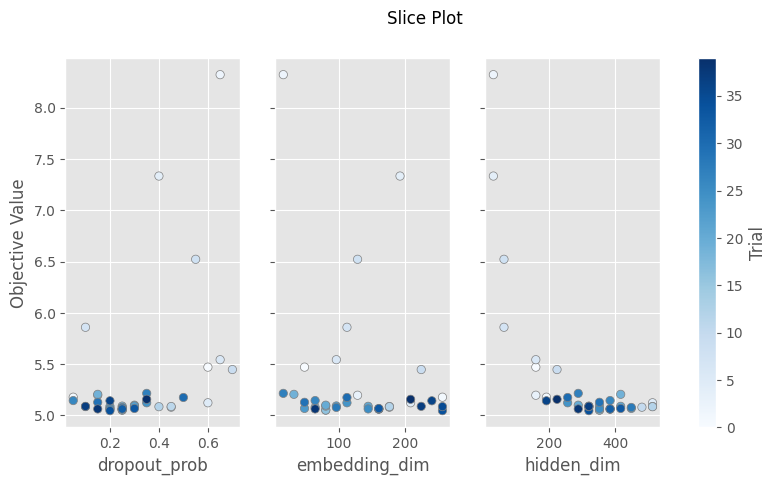

Epoch 1/50, Train Loss: 2.1789, Val Perplexity: 6.8417
Epoch 2/50, Train Loss: 1.8704, Val Perplexity: 5.9471
Epoch 3/50, Train Loss: 1.7544, Val Perplexity: 5.5385
Epoch 4/50, Train Loss: 1.6844, Val Perplexity: 5.3546
Epoch 5/50, Train Loss: 1.6396, Val Perplexity: 5.2226
Epoch 6/50, Train Loss: 1.6044, Val Perplexity: 5.1729
Epoch 7/50, Train Loss: 1.5758, Val Perplexity: 5.1140
Epoch 8/50, Train Loss: 1.5547, Val Perplexity: 5.1016
Epoch 9/50, Train Loss: 1.5384, Val Perplexity: 5.1201
Epoch 10/50, Train Loss: 1.5242, Val Perplexity: 5.0815
Epoch 11/50, Train Loss: 1.5088, Val Perplexity: 5.1014
Epoch 12/50, Train Loss: 1.5003, Val Perplexity: 5.1093
Epoch 13/50, Train Loss: 1.4935, Val Perplexity: 5.0471
Epoch 14/50, Train Loss: 1.4856, Val Perplexity: 5.0662
Epoch 15/50, Train Loss: 1.4775, Val Perplexity: 5.0951
Epoch 16/50, Train Loss: 1.4731, Val Perplexity: 5.0886
Epoch 17/50, Train Loss: 1.4666, Val Perplexity: 5.1064
Epoch 18/50, Train Loss: 1.4637, Val Perplexity: 5.1052
E

In [42]:
val_dataset = CharDataset(corpora_tokens["val"], token2index)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

def objective(trial: optuna.trial.Trial) -> float:
    embedding_dim = trial.suggest_int("embedding_dim", 16, 256, step=16)
    hidden_dim = trial.suggest_int("hidden_dim", 32, 512, step=32)
    dropout_prob = trial.suggest_float("dropout_prob", 0.05, 0.7, step=0.05)

    model, best_perplexity = train_language_model(
        train_loader=train_loader,
        val_loader=val_loader,
        vocab_size=len(vocabulary),
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        dropout_prob=dropout_prob,
    )

    return best_perplexity

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

print("Best hyperparameters:", study.best_params)

optuna.visualization.matplotlib.plot_slice(study)
plt.show()

best_params = study.best_params
final_model, _ = train_language_model(
    train_loader=train_loader,
    val_loader=val_loader,
    vocab_size=len(vocabulary),
    embedding_dim=best_params["embedding_dim"],
    hidden_dim=best_params["hidden_dim"],
    dropout_prob=best_params["dropout_prob"]
)

final_model = final_model.to(device)


## 3) Generation and evaluation

Now you need to use your language model with a beam search algorithm in order to expand partially written words into the most probable full words.
It's important to be able to test the beam search algorithm once it is written, but since the predictions of the language model are not predictable and thus a test code using it is also unpredictable, we'll need to use a mock model.
A mock model is a substitute for the trained model but which does not use any machine learning, only hard coded values.

The below mock model works just like a language model but gives a high probability to the following words only: a, the, these, and alphabet.
Any input prefix which is not a prefix of one of the previous four words will encourage a beam search algorithm to stop generating anything further.

In [43]:
class Mock(torch.nn.Module):

    def __init__(self, vocabulary, token2index, pad_index, edge_index):
        super().__init__()
        self.vocabulary = vocabulary
        self.token2index = token2index
        self.pad_index = pad_index
        self.edge_index = edge_index

    def _mock_prediction(self, prefix):
        logits = torch.zeros((len(vocabulary),), dtype=torch.float32, device='cpu')
        predictions = {
            '': ['t', 'a'],
            't': ['h'],
            'th': ['e'],
            'the': ['\0', 's'],
            'thes': ['e'],
            'these': ['\0'],
            'a': ['\0', 'l'],
            'al': ['p'],
            'alp': ['h'],
            'alph': ['a'],
            'alpha': ['b'],
            'alphab': ['e'],
            'alphabe': ['t'],
            'alphabet': ['\0'],
        }.get(prefix, ['\1'])
        for p in predictions:
            if p == '\0':
                logits[self.edge_index] = 10.0
            elif p == '\1':
                logits[self.edge_index] = 0.01
            else:
                logits[self.token2index[p]] = 10.0
        return logits

    def forward(self, text_indexes):
        prefixes = [
            ''.join(self.vocabulary[index] for index in indexes if index not in [pad_index, edge_index])
            for indexes in text_indexes.cpu().tolist()
        ]
        logits = torch.stack([self._mock_prediction(prefix) for prefix in prefixes], dim=0)
        logits = logits[:, None, :].tile((1, text_indexes.shape[1], 1))
        return logits


mock_model = Mock(vocabulary, token2index, pad_index, edge_index)

Do the following tasks:

3.1) Write a function that takes a language model and a prefix of a string word (plus any other parameters you want) and uses beam search to generate the most probable word that begins with the given prefix.
The function should only return a single string, which is the complete generated word.
Use the given code to test the function you wrote.

[15 marks]

In [44]:
def beam_search(
    model,
    prefix: str,
    vocabulary: list,
    token2index: dict,
    beam_width: int = 3,
    max_length: int = 15
) -> str:
    eos_index = token2index["<EDGE>"]
    beams = [(prefix, 0)]
    completed_words = []

    for _ in range(max_length):
        candidates = []
        for seq, log_prob in beams:
            if seq.endswith("<EDGE>"):
                completed_words.append((seq, log_prob))
                continue

            if seq:
                tokenized_seq = [token2index.get(char, token2index["<UNK>"]) for char in seq]
            else:
                tokenized_seq = [token2index["<EDGE>"]]

            text_indexes = torch.tensor(
                [tokenized_seq],
                dtype=torch.long,
                device=device
            )

            logits = model(text_indexes)
            if logits.size(1) == 0:
                continue
            probs = torch.nn.functional.softmax(logits[0, -1], dim=0)

            for token, prob in enumerate(probs):
                next_char = vocabulary[token]
                new_seq = seq + next_char
                new_log_prob = log_prob + prob.log().item()
                candidates.append((new_seq, new_log_prob))

        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        if all(seq.endswith("<EDGE>") for seq, _ in beams):
            completed_words.extend(beams)
            break

    if completed_words:
        shortest_word = min(completed_words, key=lambda x: len(x[0]))[0]
        return shortest_word.rstrip("<EDGE>")

    return beams[0][0]


In [45]:
# Do not change except where requested.

print('prefix    expected  output    pass?')
for (prefix, expected) in [
    ('', 'a'),
    ('a', 'a'),
    ('al', 'alphabet'),
    ('alphabet', 'alphabet'),
    ('t', 'the'),
    ('th', 'the'),
    ('thes', 'these'),
    ('tho', 'tho'),
    ('those', 'those'),
    ('c', 'c'),
    ('cat', 'cat'),
]:
  output = beam_search(
      mock_model,
      prefix=prefix,
      vocabulary=mock_model.vocabulary,
      token2index=mock_model.token2index,
      beam_width=3,
      max_length=15
  )
  print(f'{prefix: <8}  {expected: <8}  {output: <8}  {expected == output}')

prefix    expected  output    pass?
          a         a         True
a         a         a         True
al        alphabet  alphabet  True
alphabet  alphabet  alphabet  True
t         the       the       True
th        the       the       True
thes      these     these     True
tho       tho       tho       True
those     those     those     True
c         c         c         True
cat       cat       cat       True


3.2) Write a function that counts the number of 'taps' needed to write a word if the word was being written on a phone with your beam search function being used as a text predictor.
For example, if the word 'alphabet' is predicted after tapping 'al', then you only need two taps to enter the word.
The function should take a language model and a string word (plus any other parameters you want) and return a number.
Use the given code to test the function below.

[5 marks]

In [46]:
def taps_needed(
    model,
    word: str,
    vocabulary: list,
    token2index: dict,
    beam_width: int = 3
) -> int:
    """
    Counts the number of 'taps' needed to write a word using beam search for text prediction.

    Args:
        model (torch.nn.Module): The language model used for prediction.
        word (str): The word to be typed.
        vocabulary (list): List of tokens in the vocabulary.
        token2index (dict): Mapping of tokens to their indices.
        beam_width (int): The beam width (number of hypotheses to keep in beam search)

    Returns:
        int: Number of taps needed to write the word.
    """
    taps = 0
    prefix = ""

    for char in word:
        prediction = beam_search(
            model=model,
            prefix=prefix,
            vocabulary=vocabulary,
            token2index=token2index,
            beam_width=beam_width
        )
        if prediction == word:
            break
        else:
            prefix += char
            taps += 1

    return taps


In [47]:
# Do not change except where requested.

print('word      expected  output  pass?')
for (word, expected) in [
    ('a', 0),
    ('alphabet', 2),
    ('the', 1),
    ('these', 4),
    ('those', 5),
    ('cat', 3),
]:
    output = taps_needed(
    model=mock_model,
    word=word,
    vocabulary=mock_model.vocabulary,
    token2index=mock_model.token2index,
    beam_width=3
)
    print(f'{word: <8}  {expected: <8}  {output: <6}  {expected == output}')

word      expected  output  pass?
a         0         0       True
alphabet  2         2       True
the       1         1       True
these     4         4       True
those     5         5       True
cat       3         3       True


3.3) Calculate and display the percentage of taps saved when using the text predictor instead of typing all the words in the test set.
This is calculated as

$$\text{taps\_saved}(\text{words}) = 1 - \frac{\sum_{w \in \text{words}} \text{taps\_needed}(w)}{\sum_{w \in \text{words}} \text{len}(w)}$$

Make sure that you use the real language model you trained (not the mock model) and the words in the test set (as strings).

[5 marks]

In [48]:
def taps_saved(
    model,
    test_words: list[str],
    vocabulary: list,
    token2index: dict,
    beam_width: int = 3,
) -> float:
    """
    Calculates the percentage of taps saved using the text predictor compared to typing all words fully.

    Args:
        model (torch.nn.Module): The language model used for prediction.
        test_words (list): List of words in the test set.
        vocabulary (list): List of tokens in the vocabulary.
        token2index (dict): Mapping of tokens to their indices.
        beam_width (int): The beam width for beam search.

    Returns:
        float: Percentage of taps saved.
    """
    total_taps_without_predictor = sum(len(word) for word in test_words)

    total_taps_with_predictor = sum(
        taps_needed(
            model=model,
            word=word,
            vocabulary=vocabulary,
            token2index=token2index,
            beam_width=beam_width,
        )
        for word in test_words
    )

    taps_saved_percentage = 1 - (total_taps_with_predictor / total_taps_without_predictor)

    print(f"Total taps without predictor: {total_taps_without_predictor}")
    print(f"Total taps with predictor: {total_taps_with_predictor}")
    print(f"Taps Saved Percentage: {taps_saved_percentage * 100:.2f}%")

    return taps_saved_percentage * 100

final_model.eval()
test_set = corpora_tokens["test"]

saved_percentage = taps_saved(
    model=final_model,
    test_words=test_set,
    vocabulary=vocabulary,
    token2index=token2index,
    beam_width=3,
)
print(f"Percentage of taps saved: {saved_percentage:.2f}%")


Total taps without predictor: 18423
Total taps with predictor: 16184
Taps Saved Percentage: 12.15%
Percentage of taps saved: 12.15%
